# Normal random variables with unknown mean and variance

Consider a collection of normal random variables, $X_1, X_2, \ldots, X_N$, $N > 0$, with mean $\mu$ and variance $\sigma^2$. We write this as

$$
  (X_i \mid \mu, \sigma) \sim N(\mu, \sigma^2), \quad i = 1, 2, \ldots, N.
$$

Suppose that $\mu$ and $\sigma$ are unknown. In a Bayesian framework, we can assign a prior distribution to $\mu$ and $\sigma$. For $\mu$, we can choose a normal prior distribution with mean $\mu_0$ and variance $\sigma_0^2$. For $\sigma$, we can choose a uniform prior distribution over the range $0 < \sigma < A$. We write this as:

$$
  p(\mu) = N(\mu_0, \sigma_0^2) \text{ and }
  p(\sigma) = \frac{1}{A} \quad \text{for} \quad 0 < \sigma < A.
$$

## Sampling from the prior and likelihood

We can generate from this prior distribution:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mu_0 = 0
sigma_0 = 2
A = 10

mu = np.random.normal(mu_0, sigma_0, size=1)
sigma = np.random.uniform(0, A, size=1)
print(mu, sigma)

[0.62795685] [9.36241712]


We can draw $K$ samples using numpy as follows:

In [3]:
K = 4
mu_batch_example = np.random.normal(mu_0, sigma_0, size=K)
sigma_batch_example = np.random.uniform(0, A, size=K)

print(mu_batch_example, sigma_batch_example)

[-0.59102181  3.3679986  -1.53540932  0.10309256] [4.73106191 3.41636352 3.72894443 7.98290943]


Conditioned on a value of $\sigma$, we can generate $N$ samples $x_1, x_2, \ldots, x_N$ from their distribution (the likelihood) as follows. Equivalently we can let $\mathbf{x} = (x_1, x_2, \ldots, x_N)$ be a random variable drawn from the likelihood.

In [5]:
N = 64
x = np.random.normal(mu, sigma, size=N)
print(x)

[ -4.02483233   1.84871135  -2.70734568   2.25721334  10.04739259
   7.39406276   0.50170287 -11.65590216  -3.40012789   0.89590643
 -14.92090642  17.15559264   1.40780648  -5.05058221   5.92021695
  -4.21731099   3.93285578  -7.5444458  -13.47243803  -0.57128887
   9.06885922  17.28161503   8.08156917   8.89730625  10.13240652
  -2.09655763  -2.24635761  10.53848243  -1.52331371   8.43546308
 -10.14092323   6.34838642 -11.08966251  12.0626584   -5.225989
  -3.28755475  -0.96357872   1.61304271   1.35615312  14.71409256
  -8.42702196   3.6633307  -20.15719716  11.27862771 -19.10083971
  -3.14864744   7.83910479   2.2994285   11.34771563   2.43126289
   9.80908539   1.22635948   0.72373195   9.36089872  -1.84344639
  -1.9929878  -10.56456315   1.70648086  -1.81396404  -3.25451739
 -11.37473578  -7.75461839   6.453766    -3.10840921]


For a batch of $K$ values of $\sigma_k$, $k = 1, 2, \ldots, K$, we can generate $K$ batches of $\mathbf{x}_k$, where each batch has standard deviation $\sigma_k$ as follows:

In [6]:
x_batch_example = np.random.normal(
  mu_batch_example.reshape(-1, 1),
  sigma_batch_example.reshape(-1, 1),
  size=(K, N)
)

print(x_batch_example.shape)

(4, 64)


We can see compute the empirical mean and standard deviation of each batch to see how it varies with $\mu$ and $\sigma$ as follows:

In [8]:
x_batch_example_mean = np.mean(x_batch_example, axis=1)
x_batch_example_std = np.std(x_batch_example, axis=1)

print("Means:")
print(mu_batch_example)
print(x_batch_example_mean)
print("Standard deviations:")
print(sigma_batch_example)
print(x_batch_example_std)

Means:
[-0.59102181  3.3679986  -1.53540932  0.10309256]
[-0.20316916  3.33651742 -1.40321007 -1.39436712]
Standard deviations:
[4.73106191 3.41636352 3.72894443 7.98290943]
[4.82204255 3.84167139 3.32164806 7.64719578]


As expected, the empirical values are close to the true values.

## Sampling from the posterior with Stan

Now, to do posterior inference, we can find the posterior distribution of $\mu$ and $\sigma$ given the data $\mathbf{x}$ as follows:

$$
  p(\mu, \sigma \mid \mathbf{x}) = \frac{p(\mathbf{x} \mid \mu, \sigma) p(\mu, \sigma)}{p(\mathbf{x})} \propto p(\mathbf{x} \mid \mu, \sigma) p(\mu, \sigma)
$$

This can be simplified to:

$$
  p(\sigma \mid \mathbf{x})
    \propto
      \frac{1}{A \sigma_0} \exp\left(-\frac{\mu^2}{2\sigma_0^2}\right)
      \prod_{i=1}^N \frac{1}{\sigma} \exp\left(-\frac{x_i^2}{2\sigma^2}\right)
  \quad \text{ for } 0 < \sigma < A, \text{ or } 0 \text{ otherwise.}
$$

We will use Stan to sample from this distribution. That will give a collection of samples $(\mu^{[1]}, \sigma^{[1]}), (\mu^{[2]}, \sigma^{[2]}), \ldots, (\mu^{[S]}, \sigma^{[S]})$.

Stan models are specified in a language called Stan. You can see an eample in `p2_normal_variance.stan`, which matches the mathematical formulation above. Below we load this model using the `cmdstanpy` package (this may take some time):

In [10]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file='p2_normal_mean_variance.stan')

09:07:41 - cmdstanpy - INFO - compiling stan file /Users/mgnb/Library/CloudStorage/Dropbox/UWA/Projects/2025_Chew_Honours/20250415_toy_problems/p2_normal_mean_variance.stan to exe file /Users/mgnb/Library/CloudStorage/Dropbox/UWA/Projects/2025_Chew_Honours/20250415_toy_problems/p2_normal_mean_variance
09:07:57 - cmdstanpy - INFO - compiled model executable: /Users/mgnb/Library/CloudStorage/Dropbox/UWA/Projects/2025_Chew_Honours/20250415_toy_problems/p2_normal_mean_variance


We can initiate sampling for a single batch (the first batch in what was drawn above) as follows:

In [11]:
fit = model.sample(data={'N': N, 'x': x_batch_example[0], 'mu_0': mu_0, 'sigma_0': sigma_0, 'A': A})

09:08:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


09:08:07 - cmdstanpy - INFO - CmdStan done processing.


The samples can be accessed as follows:

In [12]:
mu_samples = fit.stan_variable('mu')
sigma_samples = fit.stan_variable('sigma')
print(mu_samples)
print(sigma_samples)

[-0.0111707 -0.713285  -0.713285  ... -0.790068   0.570791  -1.04631  ]
[5.37981 4.58345 4.58345 ... 4.62778 5.03488 4.89945]


We can summarise the samples using the `summary` method:

In [13]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-132.786000,0.025398,1.019930,0.711648,-134.88800,-132.47800,-131.824000,1711.40,2081.14,1.00063
mu,-0.183606,0.010197,0.581507,0.592961,-1.12226,-0.17513,0.760176,3251.65,2342.04,1.00024
sigma,4.946910,0.007910,0.448177,0.447115,4.26570,4.91836,5.734220,3296.33,2387.59,1.00192


Let's draw a histogram of the samples and mark the true value of $\sigma$ as a vertical line:

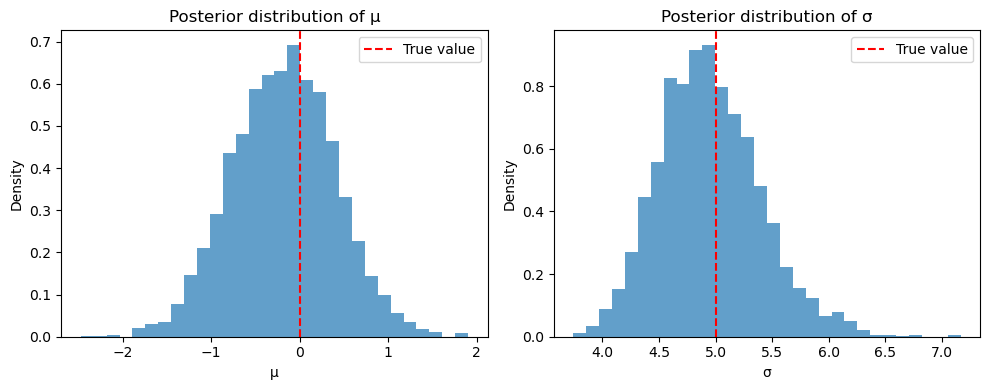

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot histogram of mu samples
ax1.hist(mu_samples, bins=30, alpha=0.7, density=True)
ax1.axvline(x=0, color='red', linestyle='--', label='True value')
ax1.set_xlabel('μ')
ax1.set_ylabel('Density')
ax1.set_title('Posterior distribution of μ')
ax1.legend()

# Plot histogram of sigma samples
ax2.hist(sigma_samples, bins=30, alpha=0.7, density=True)
ax2.axvline(x=5, color='red', linestyle='--', label='True value')
ax2.set_xlabel('σ')
ax2.set_ylabel('Density')
ax2.set_title('Posterior distribution of σ')
ax2.legend()

plt.tight_layout()
plt.show()


The true values seems to be neatly within the posterior distribution.

## Neural network inference

We can now use a neural network to do inference instead. Let's target the posterior mean.

The neural network will take the data $\mathbf{x}$ as input and output an estimate of the posterior mean of the vector $\boldsymbol{\theta} = (\mu, \sigma)$. More precisely, we want to train $\mathbf{f}_{\boldsymbol{\phi}}$ such that $\mathbf{f}_{\boldsymbol{\phi}}(\mathbf{x}) \approx E[ \boldsymbol{\theta} \mid \mathbf{x}]$, where $\mathbf{f}_{\boldsymbol{\phi}}$ is a neural network with parameters $\boldsymbol{\phi}$.


We will train the network on pairs $(\boldsymbol{\theta}, \mathbf{x})$ drawn from the joint distribution. The features are the values of $\mathbf{x}$ and the target is $\boldsymbol{\theta}$. To get the neural network to target the posterior mean, we can use the mean-squared error loss function:
$$
  L(\boldsymbol{\theta}, \mathbf{f}_{\boldsymbol{\phi}}(\mathbf{x})) = || \boldsymbol{\theta} - \mathbf{f}_{\boldsymbol{\phi}}(\mathbf{x})||_2^2,
$$
where $||\cdot||_2$ is the Euclidean norm.

**Exercise:** Implement this by generalising the code from Problem 1. You will need to modify the network to output a vector of size 2 instead of 1, and perhaps change other things.